In [51]:
import spacy
from spacy.lang.en import English
from spacy.tokens import Doc

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

sns.set_style('darkgrid')
cmap = sns.cm.mako_r

%matplotlib inline


english_words = set(corpus.words.words())



In [ ]:

import nltk
nltk.download('words')

In [21]:
wsb = pd.read_csv('/Users/jeremiahkamama/Desktop/Spacy-Analysis/data/reddit_wsb.csv')

wsb.head()
#data_wsb.info()



,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [23]:
wsb.drop(columns=['id'])

,title,score,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56
...,...,...,...,...,...,...,...
38636,NCLH 💎🙌🚀🌕 YOLO update!!!,19,https://i.redd.it/v0k8a7s00uk61.png,5,1.614814e+09,NaN,2021-03-04 01:27:07
38637,Adding to $RKT 300 more to 1000 on morning pul...,59,https://i.redd.it/z0k1zy3nytk61.jpg,76,1.614814e+09,NaN,2021-03-04 01:19:25
38638,Started at 5k a few weeks ago. Now it’s time f...,44,https://i.redd.it/ih9442fkytk61.jpg,26,1.614814e+09,NaN,2021-03-04 01:19:01
38639,Posted yesterday about buying GME 104 @ $122.9...,864,https://i.redd.it/mor1g3z9ytk61.jpg,22,1.614813e+09,NaN,2021-03-04 01:17:22


In [24]:
wsb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38641 entries, 0 to 38640
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      38641 non-null  object 
 1   score      38641 non-null  int64  
 2   id         38641 non-null  object 
 3   url        38641 non-null  object 
 4   comms_num  38641 non-null  int64  
 5   created    38641 non-null  float64
 6   body       19244 non-null  object 
 7   timestamp  38641 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.4+ MB


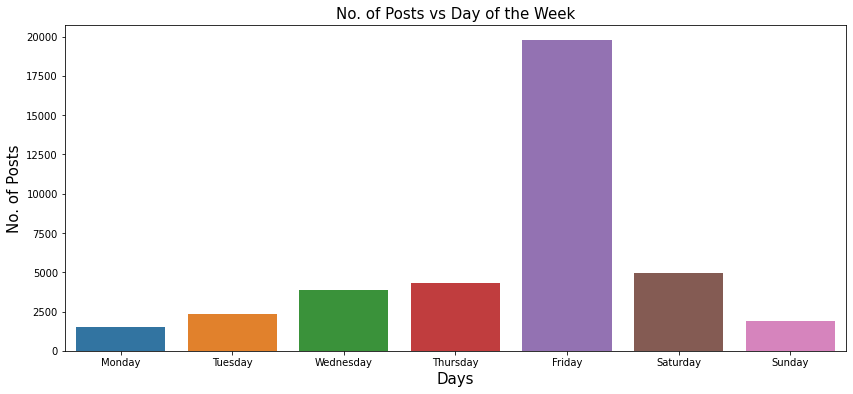

In [28]:
wsb['timestamp'] = pd.to_datetime(wsb['timestamp'])

day_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
days_order = list(day_of_the_week.values())

wsb['Weekday'] = wsb['timestamp'].apply(lambda x : day_of_the_week[x.weekday()])

xs = wsb['Weekday'].value_counts().index
ys = wsb['Weekday'].value_counts().values

plt.figure(figsize=(14,6))

sns.barplot(x=xs, y=ys, order=days_order)

plt.title("No. of Posts vs Day of the Week", fontsize=15)

plt.xlabel("Days", fontsize=15)
plt.ylabel("No. of Posts", fontsize=15)

plt.show()

In [35]:
wsb_title = wsb['title'].dropna()
wsb_body = wsb['body'].dropna()


def clean_text_date(text):
    text = text.lower()

    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

    
# Text Preprocessing
wsb_title = wsb_title.apply(lambda x : clean_text_date(x))
wsb_body = wsb_body.apply(lambda x : clean_text_date(x))

In [47]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeremiahkamama/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

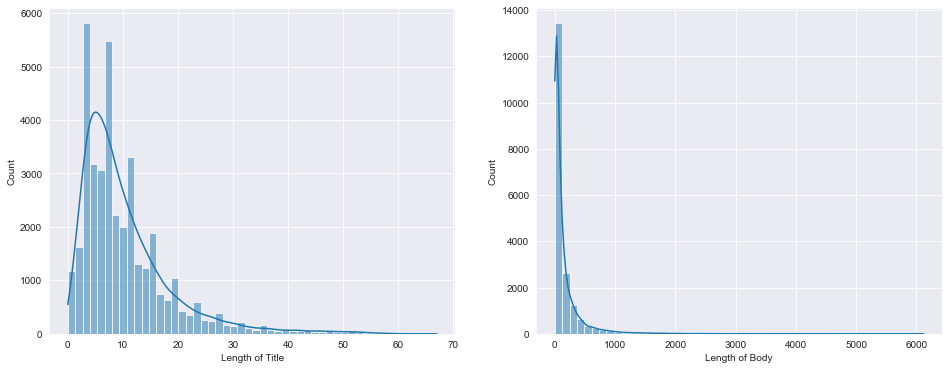

In [49]:
title_length = [len(word_tokenize(text)) for text in wsb_title]
body_length = [len(word_tokenize(text)) for text in wsb_body]

fig, (axis1, axis2) = plt.subplots(1,2, figsize=(16,6))
sns.histplot(title_length, bins=50, kde=True, ax= axis1)
sns.histplot(body_length, bins=50, kde=True, ax= axis2)

axis1.set_xlabel("Length of Title")
axis2.set_xlabel("Length of Body")

plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jeremiahkamama/nltk_data...


True